In [1]:
%env OMP_NUM_THREADS=8

env: OMP_NUM_THREADS=8
env: OMP_NUM_THREADS=8
env: OMP_NUM_THREADS=8


In [2]:
%pylab inline
import time
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import theano
theano.config.floatX = 'float32'
import theano.tensor as T

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [3]:
from itertools import *
import pickle
#from hep_ml.reweight import BinsReweighter
import numpy as np
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split

In [4]:
%load_ext autoreload
%autoreload 2

import dem

In [8]:
%pylab inline
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

class xgbClf:
    xgb_clf = xgb.XGBClassifier(n_estimators=2000, learning_rate=0.05, max_depth = 5, min_child_weight = 2)
    xtest_ex = []
    def __init__(self, photons_init_str, pi0s_init_str):
        X_train,X_val,y_train,y_val, w_train, w_val = dem.preprocess(pi0s_init_str, photons_init_str)
        self.xtest_ex = X_val
        print "preprocessing succeed"
        a = dem.rev_(X_train)
        print a.shape
        self.xgb_clf.fit(dem.rev_(X_train), y_train, w_train)
        self.write("my_little_clf.pcl")
        print "fitting succeed"
        valid_answ = self.xgb_clf.predict_proba(dem.rev_(X_val))
        print "On val:", roc_auc_score(y_val, valid_answ[:,1])
        fpr_, tpr_, thresholds_ = roc_curve(y_val, valid_answ[:,1])
        plt.plot(fpr_, tpr_, label="Roc-Curve")
        plt.savefig("2area_all.png")
        
    def predict_prob(self,test_sample):
        return self.xgb_clf.predict_proba(test_sample)
    def write (self, file_name):
        import pickle
        print "storing classifier in file", file_name,"...",
        pickle.dump(self.xgb_clf, open (file_name, "wb"))
        print " ...done"

Populating the interactive namespace from numpy and matplotlib


X_all shape (204546, 2, 5, 5)
preprocessing succeed
(153409, 50)
storing classifier in file my_little_clf.pcl ...  ...done
fitting succeed
On val: 0.961683035572


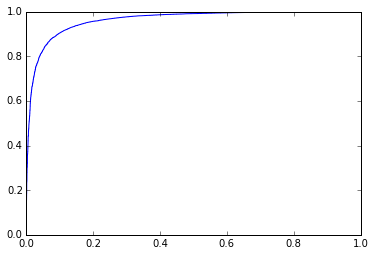

In [9]:
clf = xgbClf("../preprocessed_data/Area2Pi.pcl", "../preprocessed_data/Area2Ph.pcl")

**Сэмплом**

In [30]:
answ_ex = clf.predict_prob(dem.rev_(clf.xtest_ex))
print len(answ_ex)

5000


** По одному квадрату**

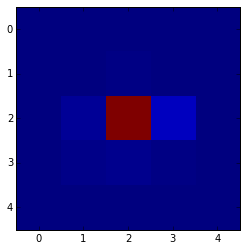

prob [[ 0.16780955  0.83219045]]


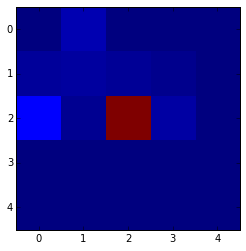

prob [[ 0.1353178  0.8646822]]


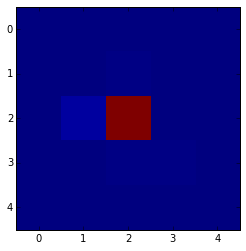

prob [[ 0.02460259  0.97539741]]


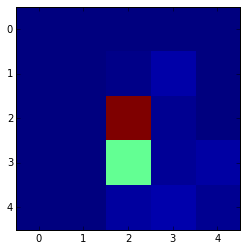

prob [[ 0.01442575  0.98557425]]


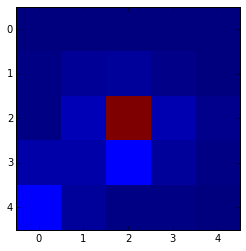

prob [[ 0.04585814  0.95414186]]


In [38]:
import matplotlib.pyplot as plt

for square in clf.xtest_ex[20:25]:
    plt.imshow(square[0].reshape(5,5), interpolation='nearest')
    plt.show()
    print "prob", clf.predict_prob(square.reshape(1,50))